# **QE: optimal growth model**

Dong Gyun Ko <br>

last updated: september 15, 2023 <br>

source: quantecon <br>

In [ ]:
# install libraries

!pip install quantecon
!pip install interpolation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.8/214.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 23.1
    Uninstalling packaging-23.1:
      Successfully uninstalled packaging-23.1


In [ ]:
# import libraries

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar

from interpolation import interp
from numba import jit, njit
from quantecon.optimize.scalar_maximization import brent_max

from quantecon.optimize import brentq

# **1. the stochastic optimal growth model**

In [ ]:
# maximize function

def maximize(g, a, b, args):

    """
    maximize the function g over the interval [a, b].
    we use the fact that the maximizer of g on any interval is also the minimizer of -g.
    the tuple args collects any extra arguments to g.
    returns the maximal value and the maximizer.
    """

    objective = lambda x: -g(x, *args)

    result = minimize_scalar(objective, bounds=(a, b), method='bounded')
    maximizer, maximum = result.x, -result.fun

    return maximizer, maximum

In [ ]:
# true value function

def v_star(y, α, β, μ):

    c1 = np.log(1 - α * β) / (1 - β)
    c2 = (μ + α * np.log(α * β)) / (1 - α)
    c3 = 1 / (1 - β)
    c4 = 1 / (1 - α * β)

    return c1 + c2 * (c3 - c4) + c4 * np.log(y)

In [ ]:
# optimal policy function

def σ_star(y, α, β):

    return (1 - α * β) * y

In [ ]:
# optimal growth model class

class OptimalGrowthModel:

    def __init__(self,
                 u,            # utility function
                 f,            # production function
                 β=0.96,       # discount factor
                 μ=0,          # shock location parameter
                 s=0.1,        # shock scale parameter
                 grid_max=4,
                 grid_size=120,
                 shock_size=250,
                 seed=1234):

        self.u, self.f, self.β, self.μ, self.s = u, f, β, μ, s

        # set up grid
        self.grid = np.linspace(1e-4, grid_max, grid_size)

        # store shocks (with a seed, so results are reproducible)
        np.random.seed(seed)
        self.shocks = np.exp(μ + s * np.random.randn(shock_size))

    def state_action_value(self, c, y, v_array):

        """
        right hand side of the Bellman equation.
        """

        u, f, β, shocks = self.u, self.f, self.β, self.shocks

        v = interp1d(self.grid, v_array)

        return u(c) + β * np.mean(v(f(y - c) * shocks))

In [ ]:
# Bellman operator

def T(v, og):

    """
    the Bellman operator.  updates the guess of the value function
    and also computes a v-greedy policy.

      * og is an instance of OptimalGrowthModel
      * v is an array representing a guess of the value function

    """
    v_new = np.empty_like(v)
    v_greedy = np.empty_like(v)

    for i in range(len(grid)):
        y = grid[i]

        # maximize RHS of Bellman equation at state y
        c_star, v_max = maximize(og.state_action_value, 1e-10, y, (y, v))
        v_new[i] = v_max
        v_greedy[i] = c_star

    return v_greedy, v_new

In [ ]:
α = 0.4

def fcd(k):
    return k**α

og = OptimalGrowthModel(u=np.log, f=fcd)

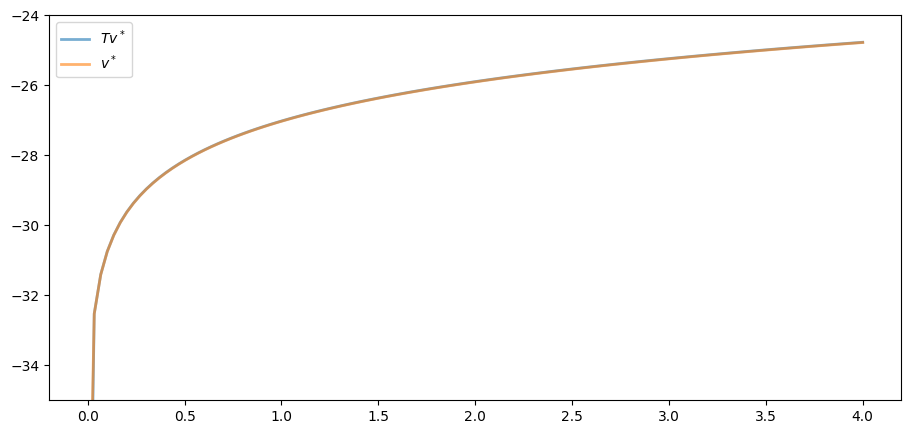

In [ ]:
grid = og.grid

v_init = v_star(grid, α, og.β, og.μ)    # start at the solution
v_greedy, v = T(v_init, og)             # apply T once

fig, ax = plt.subplots()

ax.set_ylim(-35, -24)
ax.plot(grid, v, lw=2, alpha=0.6, label='$Tv^*$')
ax.plot(grid, v_init, lw=2, alpha=0.6, label='$v^*$')
ax.legend()

plt.show()

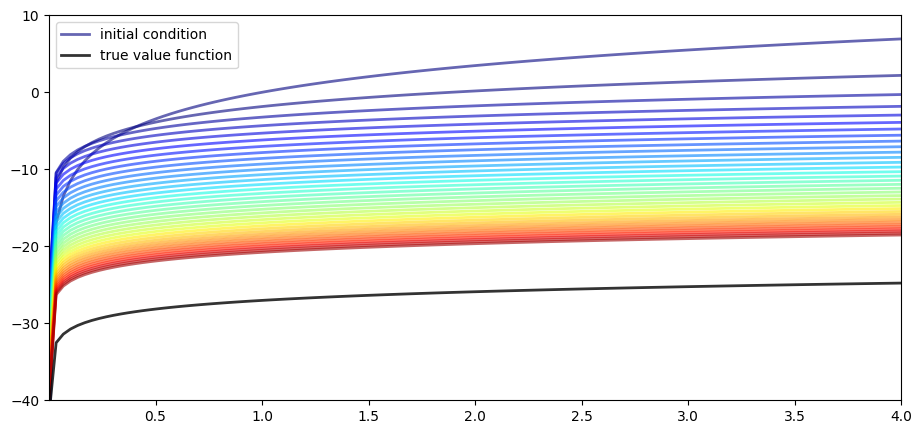

In [ ]:
v = 5 * np.log(grid)  # an initial condition
n = 35

fig, ax = plt.subplots()

ax.plot(grid, v, color=plt.cm.jet(0), lw=2, alpha=0.6, label='initial condition')

for i in range(n):

    v_greedy, v = T(v, og)  # apply the Bellman operator
    ax.plot(grid, v, color=plt.cm.jet(i / n), lw=2, alpha=0.6)

ax.plot(grid, v_star(grid, α, og.β, og.μ), 'k-', lw=2, alpha=0.8, label='true value function')

ax.legend()
ax.set(ylim=(-40, 10), xlim=(np.min(grid), np.max(grid)))

plt.show()

In [ ]:
def solve_model(og,
                tol=1e-4,
                max_iter=1000,
                verbose=True,
                print_skip=25):
    """
    solve model by iterating with the Bellman operator.
    """

    # set up loop
    v = og.u(og.grid)  # initial condition
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:

        v_greedy, v_new = T(v, og)

        error = np.max(np.abs(v - v_new))
        i += 1

        if verbose and i % print_skip == 0:
            print(f"error at iteration {i} is {error}.")

        v = v_new

    if error > tol:
        print("failed to converge!")

    elif verbose:
        print(f"\nconverged in {i} iterations.")

    return v_greedy, v_new

In [ ]:
v_greedy, v_solution = solve_model(og)

error at iteration 25 is 0.40975776844490497.
error at iteration 50 is 0.1476753540823772.
error at iteration 75 is 0.05322171277213883.
error at iteration 100 is 0.019180930548646558.
error at iteration 125 is 0.006912744396029069.
error at iteration 150 is 0.002491330384817303.
error at iteration 175 is 0.000897867291303811.
error at iteration 200 is 0.00032358842396718046.
error at iteration 225 is 0.00011662020561331587.

converged in 229 iterations.


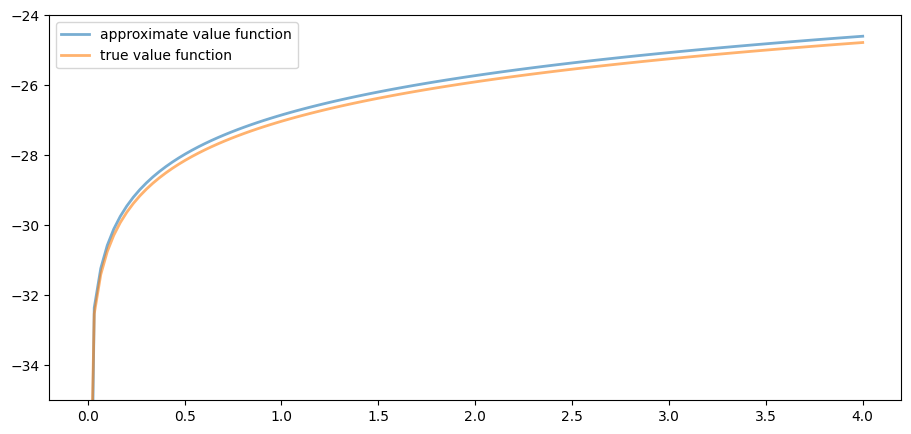

In [ ]:
fig, ax = plt.subplots()

ax.plot(grid, v_solution, lw=2, alpha=0.6,
        label='approximate value function')

ax.plot(grid, v_star(grid, α, og.β, og.μ), lw=2,
        alpha=0.6, label='true value function')

ax.legend()
ax.set_ylim(-35, -24)

plt.show()

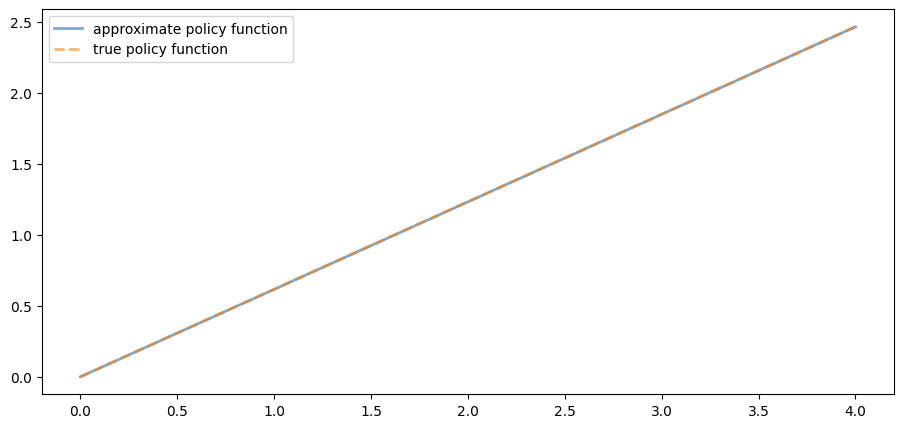

In [ ]:
fig, ax = plt.subplots()

ax.plot(grid, v_greedy, lw=2, alpha=0.6, label='approximate policy function')
ax.plot(grid, σ_star(grid, α, og.β), '--', lw=2, alpha=0.6, label='true policy function')

ax.legend()

plt.show()

## **exercise 1**

In [ ]:
γ = 1.5   # preference parameter

def u_crra(c):
    return (c**(1 - γ) - 1) / (1 - γ)

og = OptimalGrowthModel(u=u_crra, f=fcd)

In [ ]:
%%time
v_greedy, v_solution = solve_model(og)

error at iteration 25 is 0.5528151810417512.
error at iteration 50 is 0.19923228425590978.
error at iteration 75 is 0.07180266113800826.
error at iteration 100 is 0.025877443335843964.
error at iteration 125 is 0.009326145618970827.
error at iteration 150 is 0.003361112262005861.
error at iteration 175 is 0.0012113338243295857.
error at iteration 200 is 0.0004365607333056687.
error at iteration 225 is 0.00015733505506432266.

converged in 237 iterations.
CPU times: user 39 s, sys: 185 ms, total: 39.2 s
Wall time: 39.4 s


## **exercise 2**

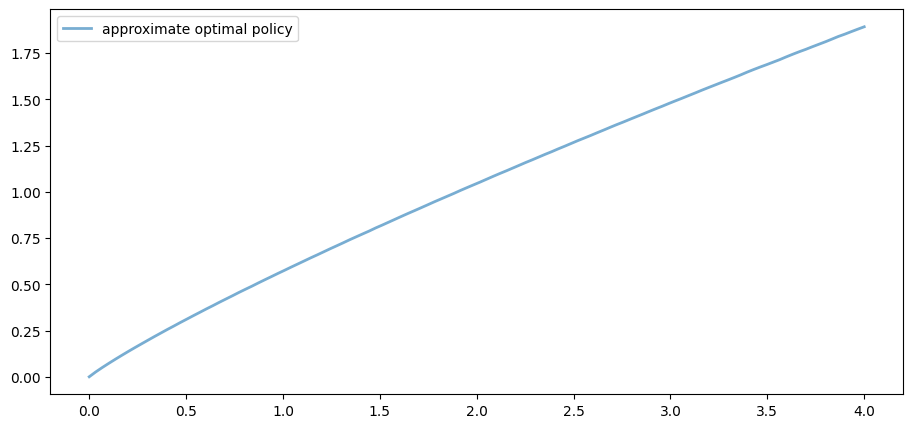

In [ ]:
fig, ax = plt.subplots()

ax.plot(grid, v_greedy, lw=2,
        alpha=0.6, label='approximate optimal policy')

ax.legend()

plt.show()

In [ ]:
v = og.u(og.grid)

In [ ]:
%%time

for i in range(20):

    v_greedy, v_new = T(v, og)
    v = v_new

CPU times: user 3.06 s, sys: 11.4 ms, total: 3.07 s
Wall time: 3.1 s


# **2. accelerating the code with numba**

In [ ]:
# true value function

def v_star(y, α, β, μ):

    c1 = np.log(1 - α * β) / (1 - β)
    c2 = (μ + α * np.log(α * β)) / (1 - α)
    c3 = 1 / (1 - β)
    c4 = 1 / (1 - α * β)

    return c1 + c2 * (c3 - c4) + c4 * np.log(y)

In [ ]:
# optimal policy function

def σ_star(y, α, β):

    return (1 - α * β) * y

In [ ]:
# optimal growth model class

from numba import float64
from numba.experimental import jitclass

opt_growth_data = [('α', float64),          # production parameter
                   ('β', float64),          # discount factor
                   ('μ', float64),          # shock location parameter
                   ('s', float64),          # shock scale parameter
                   ('grid', float64[:]),    # grid (array)
                   ('shocks', float64[:])   # shock draws (array)
                   ]

@jitclass(opt_growth_data) # using a jitclass decorator to transform a class into a quickly compiled function
class OptimalGrowthModel:

    def __init__(self,
                 α=0.4,
                 β=0.96,
                 μ=0,
                 s=0.1,
                 grid_max=4,
                 grid_size=120,
                 shock_size=250,
                 seed=1234):

        self.α, self.β, self.μ, self.s = α, β, μ, s

        # set up grid
        self.grid = np.linspace(1e-5, grid_max, grid_size)

        # store shocks (with a seed, so results are reproducible)
        np.random.seed(seed)
        self.shocks = np.exp(μ + s * np.random.randn(shock_size))


    # production function
    def f(self, k):
        return k**self.α

    # the utility function
    def u(self, c):
        return np.log(c)

    # derivative of f
    def f_prime(self, k):
        return self.α * (k**(self.α - 1))

    # derivative of u
    def u_prime(self, c):
        return 1/c

    # inverse of u
    def u_prime_inv(self, c):
        return 1/c

In [ ]:
@njit
def state_action_value(c, y, v_array, og):

    """
    right hand side of the Bellman equation.

     * c is consumption
     * y is income
     * og is an instance of OptimalGrowthModel
     * v_array represents a guess of the value function on the grid
    """

    u, f, β, shocks = og.u, og.f, og.β, og.shocks

    v = lambda x: interp(og.grid, v_array, x) # using liner interpolation

    return u(c) + β * np.mean(v(f(y - c) * shocks)) # comupting the expectation in Tv via Monte Carlo

In [ ]:
@jit(nopython=True)

def T(v, og):
    """
    the Bellman operator.

     * og is an instance of OptimalGrowthModel
     * v is an array representing a guess of the value function
    """

    v_greedy = np.empty_like(v)
    v_new = np.empty_like(v)

    for i in range(len(og.grid)):

        y = og.grid[i]

        # maximize RHS of Bellman equation at state y
        result = brent_max(state_action_value, 1e-10, y, args=(y, v, og))
        v_greedy[i], v_new[i] = result[0], result[1]

    return v_greedy, v_new

In [ ]:
def solve_model(og,
                tol=1e-4,
                max_iter=1000,
                verbose=True,
                print_skip=25):
    """
    solve model by iterating with the Bellman operator.

    """

    # set up loop
    v = og.u(og.grid)  # initial condition
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:

        v_greedy, v_new = T(v, og)
        error = np.max(np.abs(v - v_new))
        i += 1

        if verbose and i % print_skip == 0:
            print(f"error at iteration {i} is {error}.")

        v = v_new

    if error > tol:
        print("failed to converge!")

    elif verbose:
        print(f"\nconverged in {i} iterations.")

    return v_greedy, v_new

In [ ]:
og = OptimalGrowthModel()

In [ ]:
%%time
v_greedy, v_solution = solve_model(og)

error at iteration 25 is 0.41372668361363196.
error at iteration 50 is 0.14767653072604503.
error at iteration 75 is 0.053221715530355596.
error at iteration 100 is 0.019180931418503633.
error at iteration 125 is 0.006912744709538288.
error at iteration 150 is 0.002491330497818467.
error at iteration 175 is 0.0008978673320712005.
error at iteration 200 is 0.0003235884386754151.
error at iteration 225 is 0.00011662021095304453.

converged in 229 iterations.
CPU times: user 4.21 s, sys: 27.7 ms, total: 4.23 s
Wall time: 4.27 s


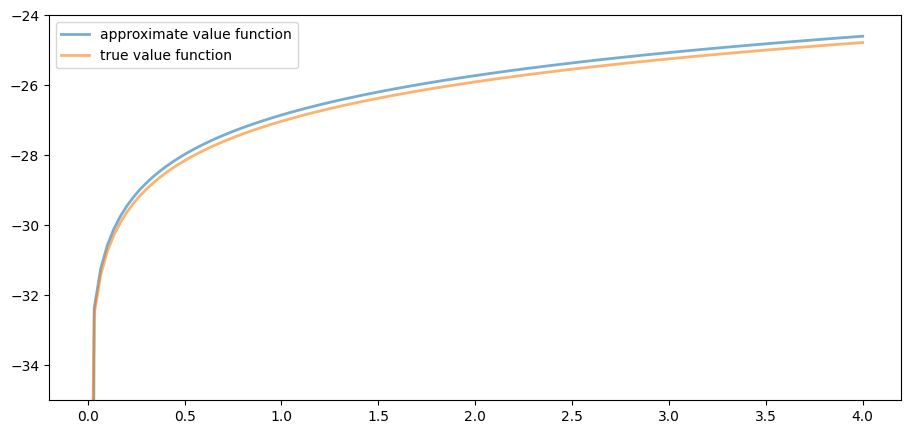

In [ ]:
# plot value function

fig, ax = plt.subplots()

ax.plot(og.grid, v_solution, lw=2, alpha=0.6, label='approximate value function')

ax.plot(og.grid, v_star(og.grid, og.α, og.β, og.μ), lw=2, alpha=0.6, label='true value function')

ax.legend()
ax.set_ylim(-35, -24)

plt.show()

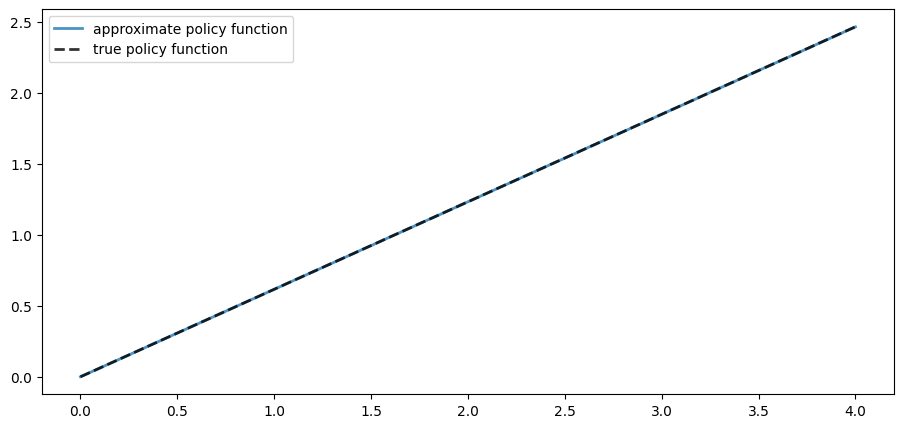

In [ ]:
# plot policy function

fig, ax = plt.subplots()

ax.plot(og.grid, v_greedy, lw=2, alpha=0.8, label='approximate policy function')
ax.plot(og.grid, σ_star(og.grid, og.α, og.β), 'k--', lw=2, alpha=0.8, label='true policy function')

ax.legend()

plt.show()

In [ ]:
np.max(np.abs(v_greedy - σ_star(og.grid, og.α, og.β)))

0.0010480539639137199

# **3.time iteration**

In [ ]:
# true value function

def v_star(y, α, β, μ):

    c1 = np.log(1 - α * β) / (1 - β)
    c2 = (μ + α * np.log(α * β)) / (1 - α)
    c3 = 1 / (1 - β)
    c4 = 1 / (1 - α * β)

    return c1 + c2 * (c3 - c4) + c4 * np.log(y)

In [ ]:
# optimal policy function

def σ_star(y, α, β):

    return (1 - α * β) * y

In [ ]:
# optimal growth model

from numba import float64
from numba.experimental import jitclass

opt_growth_data = [
    ('α', float64),          # production parameter
    ('β', float64),          # discount factor
    ('μ', float64),          # shock location parameter
    ('s', float64),          # shock scale parameter
    ('grid', float64[:]),    # grid (array)
    ('shocks', float64[:])   # shock draws (array)
]

@jitclass(opt_growth_data)
class OptimalGrowthModel:

    def __init__(self,
                 α=0.4,
                 β=0.96,
                 μ=0,
                 s=0.1,
                 grid_max=4,
                 grid_size=120,
                 shock_size=250,
                 seed=1234):

        self.α, self.β, self.μ, self.s = α, β, μ, s

        # set up grid
        self.grid = np.linspace(1e-5, grid_max, grid_size)

        # store shocks (with a seed, so results are reproducible)
        np.random.seed(seed)
        self.shocks = np.exp(μ + s * np.random.randn(shock_size))

    # the production function
    def f(self, k):
        return k**self.α

    # the utility function
    def u(self, c):
        return np.log(c)

    # derivative of f
    def f_prime(self, k):
        return self.α * (k**(self.α - 1))

    # derivative of u
    def u_prime(self, c):
        return 1/c

    # inverse of u
    def u_prime_inv(self, c):
        return 1/c

In [ ]:
@njit
def euler_diff(c, σ, y, og):
    """
    set up a function such that the root with respect to c,
    given y and σ, is equal to Kσ(y).
    """

    β, shocks, grid = og.β, og.shocks, og.grid
    f, f_prime, u_prime = og.f, og.f_prime, og.u_prime

    # first turn σ into a function via interpolation
    σ_func = lambda x: interp(grid, σ, x)

    # now set up the function we need to find the root of.
    vals = u_prime(σ_func(f(y - c) * shocks)) * f_prime(y - c) * shocks
    return u_prime(c) - β * np.mean(vals)

In [ ]:
@njit
def K(σ, og):
    """
    the Coleman-Reffett operator
    here og is an instance of OptimalGrowthModel.
    """

    β = og.β
    f, f_prime, u_prime = og.f, og.f_prime, og.u_prime
    grid, shocks = og.grid, og.shocks

    σ_new = np.empty_like(σ)

    for i, y in enumerate(grid):

        # solve for optimal c at y
        c_star = brentq(euler_diff, 1e-10, y-1e-10, args=(σ, y, og))[0]
        σ_new[i] = c_star

    return σ_new

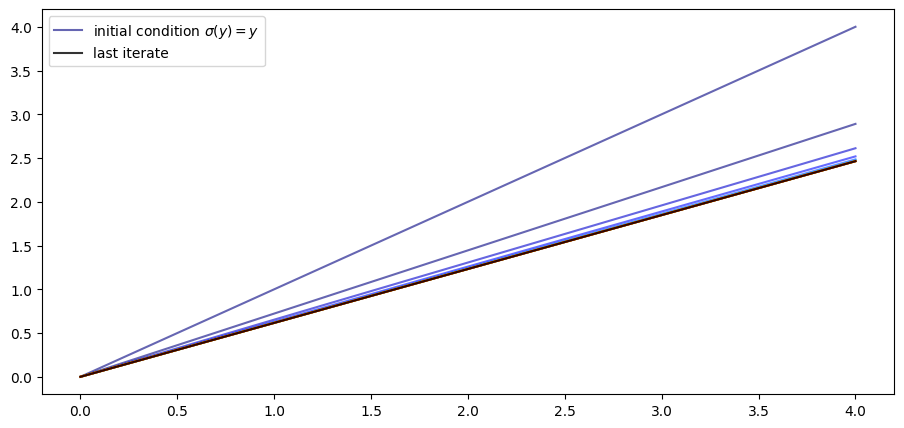

In [ ]:
og = OptimalGrowthModel()
grid = og.grid

n = 15
σ = grid.copy()  # set initial condition

fig, ax = plt.subplots()
lb = 'initial condition $\sigma(y) = y$'
ax.plot(grid, σ, color=plt.cm.jet(0), alpha=0.6, label=lb)

for i in range(n):
    σ = K(σ, og)
    ax.plot(grid, σ, color=plt.cm.jet(i / n), alpha=0.6)

# update one more time and plot the last iterate in black
σ = K(σ, og)
ax.plot(grid, σ, color='k', alpha=0.8, label='last iterate')

ax.legend()

plt.show()

In [ ]:
def solve_model_time_iter(model,    # class with model information
                          σ,        # initial condition
                          tol=1e-4,
                          max_iter=1000,
                          verbose=True,
                          print_skip=25):

    # set up loop
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        σ_new = K(σ, model)
        error = np.max(np.abs(σ - σ_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"error at iteration {i} is {error}.")
        σ = σ_new

    if error > tol:
        print("failed to converge!")
    elif verbose:
        print(f"\nconverged in {i} iterations.")

    return σ_new

In [ ]:
σ_init = np.copy(og.grid)
σ = solve_model_time_iter(og, σ_init)


converged in 11 iterations.


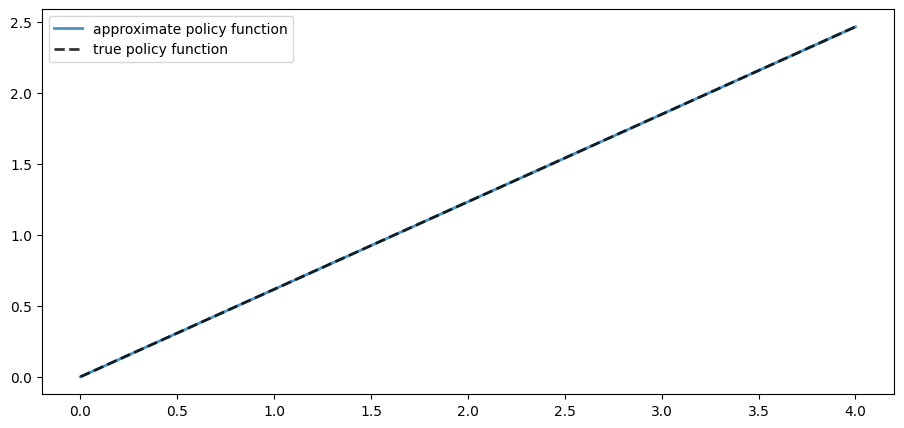

In [ ]:
fig, ax = plt.subplots()

ax.plot(og.grid, σ, lw=2,
        alpha=0.8, label='approximate policy function')

ax.plot(og.grid, σ_star(og.grid, og.α, og.β), 'k--',
        lw=2, alpha=0.8, label='true policy function')

ax.legend()
plt.show()

In [ ]:
np.max(np.abs(σ - σ_star(og.grid, og.α, og.β)))

2.5329106132954138e-05

In [ ]:
%%timeit -n 3 -r 1
σ = solve_model_time_iter(og, σ_init, verbose=False)

86.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)


## **exercise 3**

In [ ]:
# optimal growth model CRRA

from numba import float64
from numba.experimental import jitclass

opt_growth_data = [
    ('α', float64),          # production parameter
    ('β', float64),          # discount factor
    ('μ', float64),          # shock location parameter
    ('γ', float64),          # preference parameter
    ('s', float64),          # shock scale parameter
    ('grid', float64[:]),    # grid (array)
    ('shocks', float64[:])   # shock draws (array)
]

@jitclass(opt_growth_data)
class OptimalGrowthModel_CRRA:

    def __init__(self,
                 α=0.4,
                 β=0.96,
                 μ=0,
                 s=0.1,
                 γ=1.5,
                 grid_max=4,
                 grid_size=120,
                 shock_size=250,
                 seed=1234):

        self.α, self.β, self.γ, self.μ, self.s = α, β, γ, μ, s

        # Set up grid
        self.grid = np.linspace(1e-5, grid_max, grid_size)

        # Store shocks (with a seed, so results are reproducible)
        np.random.seed(seed)
        self.shocks = np.exp(μ + s * np.random.randn(shock_size))

    # the production function
    def f(self, k):
        return k**self.α

    # the utility function
    def u(self, c):
        return c**(1 - self.γ) / (1 - self.γ)

    # derivative of f
    def f_prime(self, k):
        return self.α * (k**(self.α - 1))

    # derivative of u
    def u_prime(self, c):
        return c**(-self.γ)

    # inverse of u
    def u_prime_inv(c):
        return c**(-1 / self.γ)

In [ ]:
og_crra = OptimalGrowthModel_CRRA()


converged in 13 iterations.


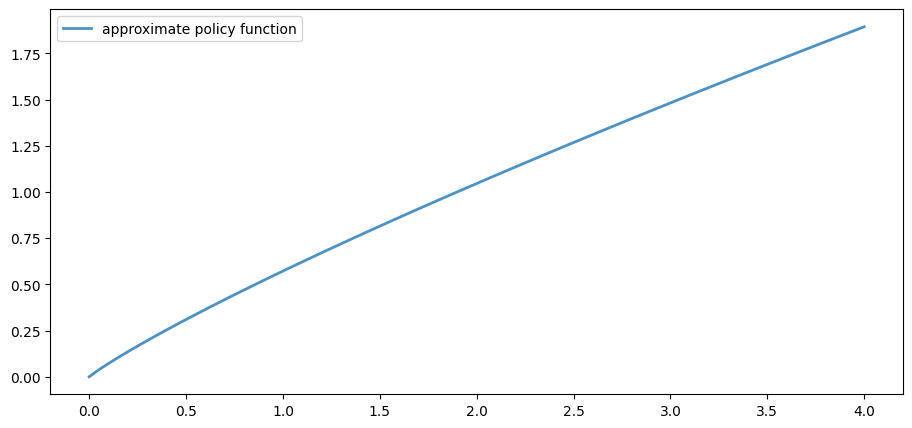

CPU times: user 2.43 s, sys: 113 ms, total: 2.54 s
Wall time: 2.43 s


In [ ]:
%%time
σ = solve_model_time_iter(og_crra, σ_init)

fig, ax = plt.subplots()

ax.plot(og.grid, σ, lw=2,
        alpha=0.8, label='approximate policy function')

ax.legend()

plt.show()

# **4. endogenous grid method**

In [ ]:
# true value function

def v_star(y, α, β, μ):

    c1 = np.log(1 - α * β) / (1 - β)
    c2 = (μ + α * np.log(α * β)) / (1 - α)
    c3 = 1 / (1 - β)
    c4 = 1 / (1 - α * β)

    return c1 + c2 * (c3 - c4) + c4 * np.log(y)

In [ ]:
# optimal policy function

def σ_star(y, α, β):

    return (1 - α * β) * y

In [ ]:
# optimal growth model

from numba import float64
from numba.experimental import jitclass

opt_growth_data = [
    ('α', float64),          # production parameter
    ('β', float64),          # discount factor
    ('μ', float64),          # shock location parameter
    ('s', float64),          # shock scale parameter
    ('grid', float64[:]),    # grid (array)
    ('shocks', float64[:])   # shock draws (array)
]

@jitclass(opt_growth_data)
class OptimalGrowthModel:

    def __init__(self,
                 α=0.4,
                 β=0.96,
                 μ=0,
                 s=0.1,
                 grid_max=4,
                 grid_size=120,
                 shock_size=250,
                 seed=1234):

        self.α, self.β, self.μ, self.s = α, β, μ, s

        # set up grid
        self.grid = np.linspace(1e-5, grid_max, grid_size)

        # store shocks (with a seed, so results are reproducible)
        np.random.seed(seed)
        self.shocks = np.exp(μ + s * np.random.randn(shock_size))

    # the production function
    def f(self, k):
        return k**self.α

    # the utility function
    def u(self, c):
        return np.log(c)

    # derivative of f
    def f_prime(self, k):
        return self.α * (k**(self.α - 1))

    # derivative of u
    def u_prime(self, c):
        return 1/c

    # inverse of u
    def u_prime_inv(self, c):
        return 1/c

In [ ]:
@njit
def K(σ_array, og):
    """
    the Coleman-Reffett operator using EGM
    """

    # simplify names
    f, β = og.f, og.β
    f_prime, u_prime = og.f_prime, og.u_prime
    u_prime_inv = og.u_prime_inv
    grid, shocks = og.grid, og.shocks

    # determine endogenous grid
    y = grid + σ_array  # y_i = k_i + c_i

    # linear interpolation of policy using endogenous grid
    σ = lambda x: interp(y, σ_array, x)

    # allocate memory for new consumption array
    c = np.empty_like(grid)

    # solve for updated consumption value
    for i, k in enumerate(grid):
        vals = u_prime(σ(f(k) * shocks)) * f_prime(k) * shocks
        c[i] = u_prime_inv(β * np.mean(vals))

    return c

In [ ]:
og = OptimalGrowthModel()
grid = og.grid

In [ ]:
def solve_model_time_iter(model,    # class with model information
                          σ,        # initial condition
                          tol=1e-4,
                          max_iter=1000,
                          verbose=True,
                          print_skip=25):

    # set up loop
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        σ_new = K(σ, model)
        error = np.max(np.abs(σ - σ_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"error at iteration {i} is {error}.")
        σ = σ_new

    if error > tol:
        print("failed to converge!")
    elif verbose:
        print(f"\nconverged in {i} iterations.")

    return σ_new

In [ ]:
σ_init = np.copy(grid)
σ = solve_model_time_iter(og, σ_init)


converged in 12 iterations.


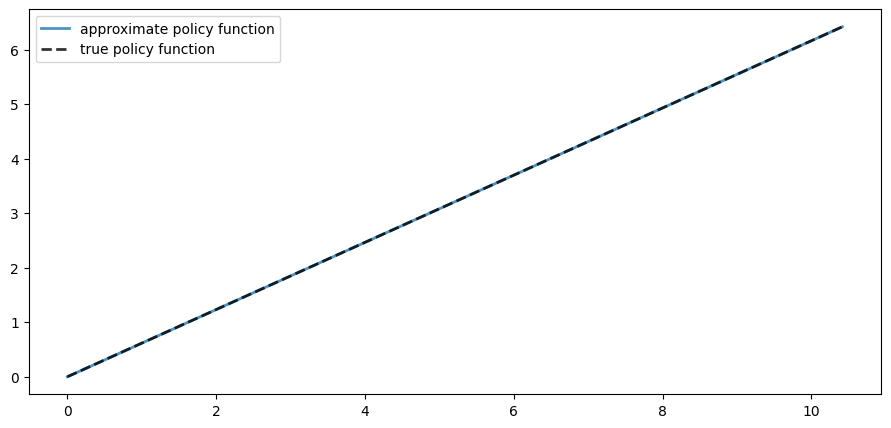

In [ ]:
y = grid + σ  # y_i = k_i + c_i

fig, ax = plt.subplots()

ax.plot(y, σ, lw=2,
        alpha=0.8, label='approximate policy function')

ax.plot(y, σ_star(y, og.α, og.β), 'k--',
        lw=2, alpha=0.8, label='true policy function')

ax.legend()

plt.show()

In [ ]:
np.max(np.abs(σ - σ_star(y, og.α, og.β)))

1.530274914252061e-05

In [ ]:
%%timeit -n 3 -r 1
σ = solve_model_time_iter(og, σ_init, verbose=False)

12.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)


# **references**

[1] [optimal growth 1: the stochastic optimal growth model](https://python.quantecon.org/optgrowth.html)

[2] [optimal growth 2: accelerating the code with numba](https://python.quantecon.org/optgrowth_fast.html)

[3] [optimal growth 3: time iteration](https://python.quantecon.org/coleman_policy_iter.html)

[4] [optimal growth 4: endogenous grid method](https://python.quantecon.org/egm_policy_iter.html)